In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import warnings

<ipython-input-1-ab89508f07af>:21: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)


In [3]:
# clrs
res_notag = ['80000','50000','5000','500']
clrs_notag_res = []
for i in range(len(res_notag)):
    x = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_"+res_notag[i]+"_raw.cool")
    clrs_notag_res.append(x)


1800000 130000
1800000 130000
I : (0, 189)
II : (189, 380)
III : (380, 553)
IV : (553, 772)
V : (772, 1034)
X : (1034, 1256)


<ipython-input-4-1e252c2e36b7>:100: RuntimeWarning: divide by zero encountered in log10
  np.log10(interp_nan(clr_region)),
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


I : (0, 189)
II : (189, 380)
III : (380, 553)
IV : (553, 772)
V : (772, 1034)
X : (1034, 1256)


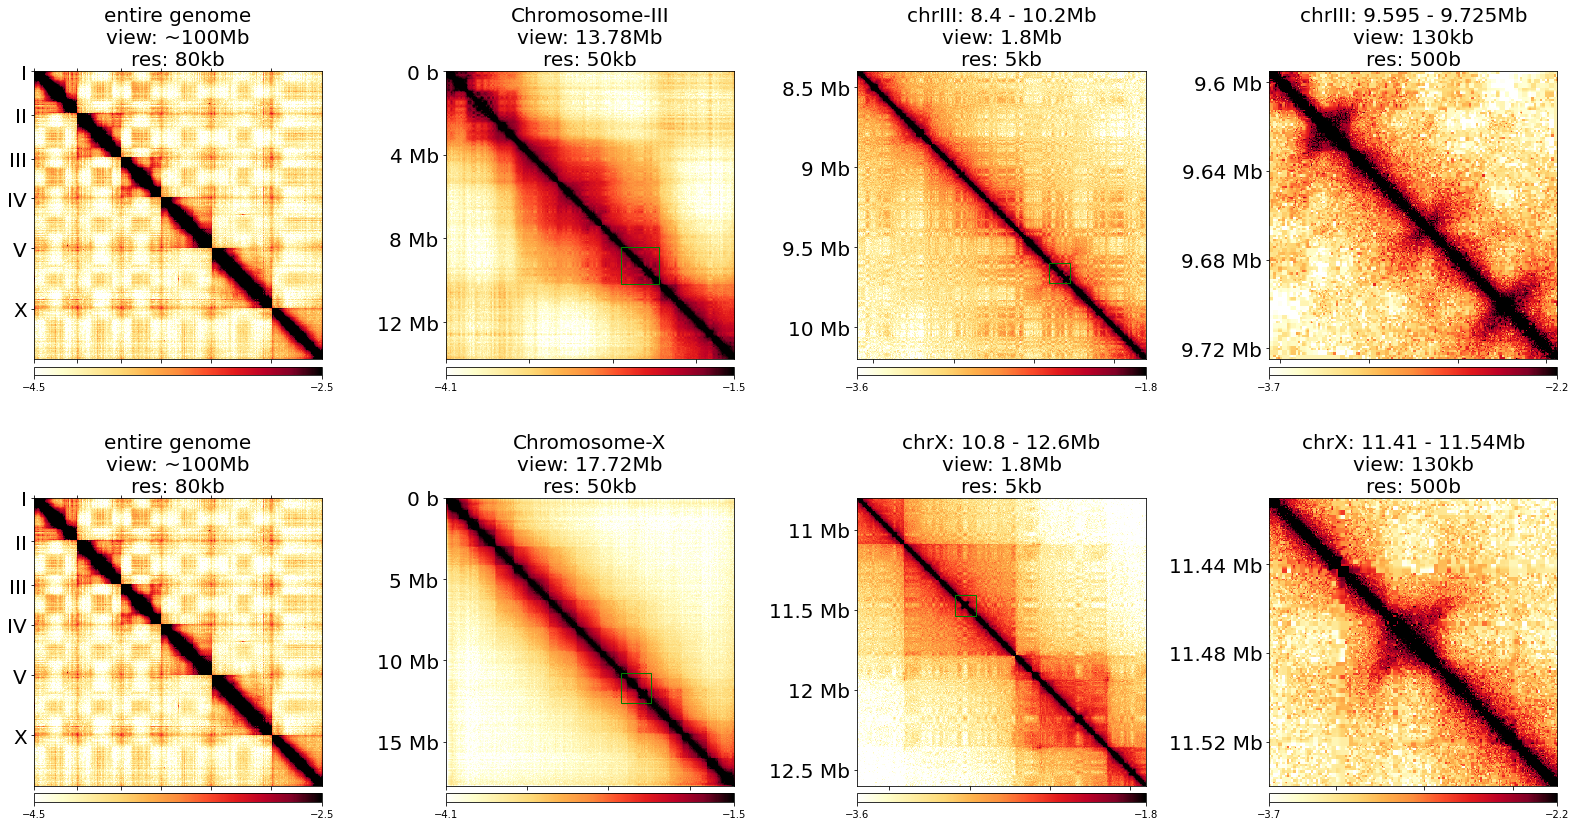

In [4]:
##### snap shot ####

f, axs = plt.subplots(
    figsize=(22, 12),
    nrows=2,
    ncols=4,
    sharex=False,
    sharey=False
)

#### data
clrs = clrs_notag_res

# params
#sub_titles = ['arm_center','compartments',"jets"]




#row_labels = ['Hi-C, 20-kb','DPY-27 \n(Ercan,2009)']
pad_param = 0.16


smallFont = 12
bigFont = 20
minmax_genome = [-4.5,-2.5]
minmax_scale = [[-4.1,-1.5],[-3.6,-1.8],[-3.7,-2.2]]
######### regions ###############
#chrom = 'III'
#s0, e0 = 0, 13_783_700
#s2,e2 = 9_595_000,9_725_000
#s1, e1 = 8_850_000, 10_150_000
#s1, e1 = e2-900_000, e2+400_000

##############################
#chrom_a = 'II'
#s0_a,e0_a = 0, 15_279_000
#s1_a,e1_a = 5_000_000,6_800_000
#s1_a,e1_a = 5_200_000,7_000_000
#5,331,709-5,620,458
#5330000	5332000
#5330000	5332000
########################################
######### regions ###############
chrom_a = 'III'
s0_a, e0_a = 0, 13_783_700
s1_a, e1_a = 8_400_000, 10_200_000
s2_a,e2_a = 9_595_000,9_725_000
print(e1_a-s1_a,e2_a-s2_a)


chrom_x = 'X'
s0_x,e0_x = 0, 17_718_000
s1_x,e1_x = 10_800_000,12_600_000
s2_x,e2_x = 11_410_000,11_540_000

print(e1_x-s1_x,e2_x-s2_x)

#################################################
ticks = [[1_000_000,13_000_000],[9_000_000,10_000_000],[9_600_000,9_720_000]]
#hic_title_r1 = ['view: 13.7Mb',
#                'view: '+str((e1-s1)/1000_000)+'Mb',
#                'view: '+str(int((e2-s2)/1000))+'kb']

#hic_yLabs = ['res: 50kb',
#             'res: 5kb',
#             'res: 500b']


######################### genome-wide plot ####################################
for r in range(2):
    if r == 0:
        chrom = chrom_a
        starts = [s0_a,s1_a,s2_a]
        ends = [e0_a,e1_a,e2_a]

    elif r == 1:
        chrom = chrom_x
        starts = [s0_x,s1_x,s2_x]
        ends = [e0_x,e1_x,e2_x]
        
    hic_title = ['entire genome\nview: ~100Mb'+'\n'+
                 'res: '+str(int(res_notag[0])//1000)+'kb',
                 
                 'Chromosome-'+chrom+'\n'+'view: '+str(round((ends[0]-starts[0])/1000_000,2))+'Mb'+'\n'+
                 'res: '+str(int(res_notag[1])//1000)+'kb',
                 
                 'chr'+chrom+': '+str(starts[1]/1000_000)+' - '+str(ends[1]/1000_000)+'Mb'+'\n'+
                 'view: '+str((ends[1]-starts[1])/1000_000)+'Mb'+'\n'+
                 'res: '+str(int(res_notag[2])//1000)+'kb',
                 
                 'chr'+chrom+': '+str(starts[2]/1000_000)+' - '+str(ends[2]/1000_000)+'Mb'+'\n'+
                 'view: '+str(int((ends[2]-starts[2])/1000))+'kb'+'\n'+
                 'res: '+str(int(res_notag[3]))+'b']

    ax = axs[r,0]
    clr_region = clrs[0].matrix()[:]

    im = ax.matshow(
            np.log10(interp_nan(clr_region)),
            cmap='fall',
            vmin=minmax_genome[0],vmax=minmax_genome[1])
    divider = make_axes_locatable(ax)


    
## color bar ##
    cax = divider.append_axes("bottom", size="3%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax,ticks=[minmax_genome[0],minmax_genome[1]],
                        orientation='horizontal')

## aesthetics ##
    chromstarts = []
    for i in clrs[0].chromnames:
        print(f'{i} : {clrs[0].extent(i)}')
        chromstarts.append((clrs[0].extent(i)[0]))
    
    ax.set_yticks(chromstarts)
    ax.set_yticklabels(clrs[0].chromnames,fontsize=bigFont)
    ax.set_xticks(chromstarts)
    ax.set_xticklabels([],fontsize=bigFont)
    ax.set_title(hic_title[0],fontsize=bigFont)
######################### diff scale plot ####################################

    for i in range(len(clrs)-1):
        ax = axs[r,i+1]
        clr_i = clrs[i+1]
        start,end = starts[i],ends[i]
        region = chrom+':'+str(start)+'-'+str(end)
        extents = [start,end,end,start]
    

        clr_region = cgi_region(clr_i,region)
        im = ax.matshow(
            np.log10(clr_region),
            cmap='fall',
            vmin=minmax_scale[i][0],vmax=minmax_scale[i][1],
            extent=extents)
## box ##
        if i < 2:
            ax.add_patch( Rectangle((starts[i+1], starts[i+1]),
                                    ends[i+1]-starts[i+1], ends[i+1]-starts[i+1],
                                    fc ='none', 
                                    ec ='green',
                                    lw = 1))

## colorbar ## 
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="3%", pad=0.1)
        cbar = plt.colorbar(im, cax=cax,ticks=[minmax_scale[i][0],minmax_scale[i][1]],
                            orientation='horizontal')

## aesthetics ##
        ax.set_title(hic_title[i+1],fontsize=bigFont)
        ax.tick_params(axis='both', which='major', labelsize=bigFont,
                      labelbottom=False, labeltop=False,labelleft=True)
        format_ticks(ax,rotate=False)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()